In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
e = constants.value(u'elementary charge')
kb = constants.value(u'Boltzmann constant')
R = constants.value(u'molar gas constant')
F = constants.value(u'Faraday constant')
Na = constants.value(u'Avogadro constant')

In [4]:
def k_arr(T, A, Ea):
    return A*np.exp(-Ea/R/T)

In [5]:
def lin(x, m, b):
    return m*x+b

In [6]:
def R2(x_values, y_values, popt):
    meany = np.mean(y_values)
    return 1-np.sum((y_values-lin(x_values, *popt))**2)/np.sum((y_values-meany)**2)

In [8]:
def jssH(T, E, k1, k_1, k2, Ev=0, alpha=0.5, cH=1):
    Eh = -Ev
    nominator = 2*F*k2*cH*np.exp(-alpha*F*(E-Eh)/R/T)
    denominator = 1/(1+k_1/(cH*k1)*np.exp(F*(E-Ev)/R/T)+k2*np.exp(-alpha*F*(E-Eh)/R/T)/(k1*np.exp(-alpha*F*(E-Ev)/R/T)))
    return nominator*denominator, denominator

In [68]:
def jssT(E, k1, k_1, k2, T, Ev=0, alpha=0.5, cH=1):
    kf = k1*cH*np.exp(-alpha*F*(E-Ev)/R/T)
    kb = k_1*np.exp((1-alpha)*F*(E-Ev)/R/T)
    kt = k2*np.exp(-2*(1-alpha)*F*Ev/R/T)
    H = (-(kf+kb)+np.sqrt((kf+kb)**2+4*kf*kt))/2/(kt)
    return 2*F*kt*H**2, H

In [27]:
def plot_constable_tafel(fit_params, model_result, E_values, cov, regions=False, nofit=False, cutoff=[0.06, 0.1], 
        k = 1, arrowE=False, arrowT=False, ind_labels=False, Exy=[44, 13.5], Earrowxy=[42, 13, 46, 13], cov_scale=[0.95, 1],
        Txy=[0.23, 6.3], Tarrowxy=[0.21, 6.7, 0.21, 6], ylim=[8, 15], xlim=[0, 0.25],
        save=False, name='DummyFigure'):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    
    ax[0, 0].set_title('a) Constable Plot', fontsize=15)
    for i in fit_params.keys():
        if k == 0:
            ax[0, 0].plot(fit_params[i][0]/1000, fit_params[i][1], 'xr', fillstyle='none')
            k += 1
        else:
            ax[0, 0].plot(fit_params[i][0]/1000, fit_params[i][1], 'ok', fillstyle='none')
    if arrowE:
        ax[0, 0].annotate("Overpotential", (Exy[0], Exy[1]), fontsize=15, ha='center', va='center')
        ax[0, 0].annotate("", (Earrowxy[0], Earrowxy[1]), xytext=(Earrowxy[2], Earrowxy[3]),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
    if ind_labels:
        ax[0, 0].annotate('-0.02 V', (47.8, 16.85), ha='center', va='center', color='blue')#
        ax[0, 0].annotate('-0.18 V', (45, 18.3), ha='center', va='center', color='blue')
        ax[0, 0].annotate('-0.11 V', (47.8, 18.2), ha='center', va='center', color='blue')
    ax[0, 0].set_xlabel('Activation Energy / kJ / mol', fontsize=15)
    ax[0, 0].set_ylabel(r'log$_{10}$(A$_\mathrm{app}$ / A m$^{-2}$)', fontsize=15)
    ax[0, 0].tick_params(axis='both', labelsize=15)
    ax[0, 0].set_ylim(ylim[0], ylim[1])

    ax[0, 1].set_title('b) Tafel Plot', fontsize=15)
    for i in range(len(model_result.T)):
        ax[0, 1].plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff[0])], np.log10(model_result.T[i][(-E_values < cutoff[0])]))
                print(f'Slope till {cutoff[0]:.2f}V: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff[1])], np.log10(model_result.T[i][(-E_values >= cutoff[1])]))
                print(f'Slope over {cutoff[1]:.2f}V: {1000/popt2[0]:.3f} mV/dec')
                ax[0, 1].plot(-E_values, lin(-E_values, *popt1), '-r')
                ax[0, 1].plot(-E_values, lin(-E_values, *popt2), '-b')
        elif nofit:
            pass
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope: {1000/popt[0]:.3f} mV/dec')
            ax[0, 1].plot(-E_values, lin(-E_values, *popt), '-r')
    if arrowT:
        ax[0, 1].annotate("Temperature", (Txy[0], Txy[1]), rotation=270, fontsize=15, ha='center', va='center')
        ax[0, 1].annotate("", (Tarrowxy[0], Tarrowxy[1]), xytext=(Tarrowxy[2], Tarrowxy[3]),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
    ax[0, 1].set_xlabel('-Overpotential / V', fontsize=15)
    ax[0, 1].set_ylabel(r'log$_{10}$(Current / A  m$^{-2}$)', fontsize=15)
    #ax.set_yscale('log')
    ax[0, 1].set_xlim(xlim[0], xlim[1])
    ax[0, 1].tick_params(axis='both', labelsize=15)

    ax[1, 0].set_title('c) Coverage', fontsize=15)
    ax[1, 0].plot(-E_values, cov, 'o-', fillstyle='none')
    #ax[1, 0].plot(-E_values, cov*1e7, 'o-', fillstyle='none')
    ax[1, 0].set_xlabel('-Overpotential / V', fontsize=15)
    ax[1, 0].set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    #ax[1, 0].set_ylabel(r'Coverage $\times 10^7$ / $\theta_\mathrm{max}$', fontsize=15)
    ax[1, 0].tick_params(axis='both', labelsize=15)
    #ax[1, 0].set_ylim(cov_scale[0], cov_scale[1])
    
    Ea = np.array([fit_params[i][0] for i in fit_params.keys()])
    A  = np.array([fit_params[i][1] for i in fit_params.keys()])
    ax[1, 1].set_title('d) Arrhenius parameters \nas a function of potential', fontsize=15)
    ax[1, 1].plot(-E_values, Ea/1000, 'ok', fillstyle='none')
    twinx = ax[1, 1].twinx()
    twinx.plot(-E_values, A, 'or', fillstyle='none')
    
    ax[1, 1].set_xlabel('-Overpotential / V', fontsize=15)
    ax[1, 1].set_ylabel('Activation Energy / kJ / mol', fontsize=15)
    ax[1, 1].tick_params(axis='both', labelsize=15)
    twinx.set_ylabel(r'log$_{10}$(A$_\mathrm{app}$ / A m$^{-2}$)', fontsize=15, color='red')
    twinx.tick_params(axis='y', labelcolor='red', labelsize=15)
    twinx.spines['right'].set_color('red')
    #twinx.yaxis.label.set_color('red')
    #twinx.set_ylim(18, 18.6)
    
    if save:
        plt.savefig(f'../../Faraday Discussion/London - 2026/Figures/{name}.png', bbox_inches='tight')
    plt.show()

In [16]:
def simulation_E_T(E_range, A1, Ea1, A_1, A2, Ea2, Ev, z, log_scale=True, regions=False, cutoff=0.1, save=False,
    name='Dummy'):
    T_values = np.linspace(273+25, 273+65, 5)
    #T_values = np.linspace(273+25, 273+1000, 20)
    E_values = np.arange(E_range[0], E_range[1], 0.01)
    #E_values = np.linspace(E_range[0], E_range[1], 3)
    params = {}
    model_result = np.zeros((len(E_values), len(T_values)))
    cov = []
    k = 0
    for E in E_values:
        params.update({f'{E:.2f}': np.array([])})
        j = 0
        for T in T_values:
            k1 = k_arr(T, A1, Ea1)
            k_1 = k_arr(T, A_1, Ea1)
            k2 = k_arr(T, A2, Ea2)
            if T == T_values.min():
                cov += [jssH(T, E, k1, k_1, k2, Ev=Ev)[1]]
            model_result[k, j] += jssH(T, E, k1, k_1, k2, Ev=Ev)[0]
            j += 1
        k += 1
    marker = ['o', 'X', 'D']
    fig, ax = plt.subplots()
    for i in range(len(model_result)):
        ax.plot(1000/T_values, model_result[i], 'ok', fillstyle='none')
        #        label=f'Overpotential = {E_values[i]:.2f} V')
        popt, pcov = curve_fit(lin, 1/T_values, np.log(model_result[i]))
        #print('R2 = ', R2(1/T_values, np.log(model_result[i]), popt))
        params[f'{E_values[i]:.2f}'] = np.append(params[f'{E_values[i]:.2f}'], [-R*popt[0], np.log10(np.exp(popt[1]))])
        ax.plot(1000/T_values, np.exp(lin(1/T_values, *popt)), '-r')
    ax.set_xlabel('1000 K / Temperature', fontsize=15)
    ax.set_ylabel(r'log(Current / A m$^{-2}$)', fontsize=15)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    #ax.annotate(r'R$^2 > 0.98$', (3, 1e14), fontsize=15, ha='center', va='center')
    #ax.legend(fontsize=15)
    if save:
        plt.savefig(f'../../Faraday Discussion/London - 2026/Figures/{name}.png', bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots()
    fig.suptitle('Tafel Plot', fontsize=15)
    for i in range(len(model_result.T)):
        ax.plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff)], np.log10(model_result.T[i][(-E_values < cutoff)]))
                print(f'Slope till {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff)], np.log10(model_result.T[i][(-E_values >= cutoff)]))
                print(f'Slope over {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt2[0]:.3f} mV/dec')
                ax.plot(-E_values, lin(-E_values, *popt1), '-r')
                ax.plot(-E_values, lin(-E_values, *popt2), '-b')
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope @ {T_values[i]:.0f}: {1000/popt[0]:.3f} mV/dec')
            ax.plot(-E_values, lin(-E_values, *popt), '-r')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'log$_{10}$(Current)', fontsize=15)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(-E_values, cov, 'o-k', fillstyle='none')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    if log_scale:
        ax.set_yscale('log')
    plt.show()
    
    return params, model_result, E_values, np.array(cov)

In [25]:
def plot_tafel_slope(fit_params, model_result, E_values, arrowT=False,
        Txy=[0.23, 125], Tarrowxy=[0.21, 130, 0.21, 120], ylim=[115, 140], inset=False,
        save=False, name='DummyFigure'):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in range(len(model_result.T)):
        TS = (E_values[0]-E_values[1])/np.diff(np.log10(model_result.T[i]))*1000
        ax.plot(-E_values[1:], TS, 'o-', fillstyle='none')
    if arrowT:
        ax.annotate("Temperature", (Txy[0], Txy[1]), rotation=270, fontsize=15, ha='center', va='center')
        ax.annotate("", (Tarrowxy[0], Tarrowxy[1]), xytext=(Tarrowxy[2], Tarrowxy[3]),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'Tafel Slope / mV / dec', fontsize=15)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(0, 0.25)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    
    if inset:
        axins = inset_axes(ax, width="50%", height="50%", loc='upper left')
        for i in range(len(model_result.T)):
            TS = (E_values[0]-E_values[1])/np.diff(np.log10(model_result.T[i]))*1000
            axins.plot(-E_values[1:], TS, 'o-', fillstyle='none')
        axins.annotate("Temperature", (0.05, 80), rotation=270, fontsize=15, ha='center', va='center')
        axins.annotate("", (0.035, 100), xytext=(0.035, 60),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
        axins.set_xlim(0.008, 0.12)
        axins.set_ylim(25, 110)
        axins.tick_params(labelleft=False, labelbottom=False)
        mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")

    if save:
        plt.savefig(f'../../Faraday Discussion/London - 2026/Figures/{name}.png', bbox_inches='tight')
    plt.show()

# Single Active Site

## Case 1.1 Volmer-Heyrovsky: Volmer RDS -> $\Delta G^\ddagger_\mathrm{act, V} >> \Delta G^\ddagger_\mathrm{act, H}$

In [19]:
A1 = 1e13
Ea1 = 50e3
A_1 = 1e13
A2 = 1e13
Ea2 = 10e3

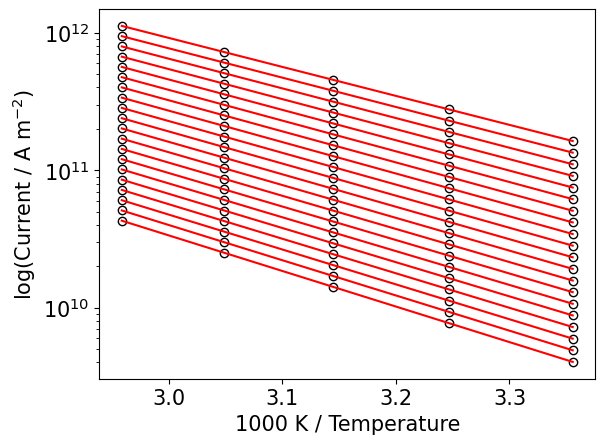

Slope @ 298: 118.259 mV/dec
Slope @ 308: 122.228 mV/dec
Slope @ 318: 126.196 mV/dec
Slope @ 328: 130.164 mV/dec
Slope @ 338: 134.133 mV/dec


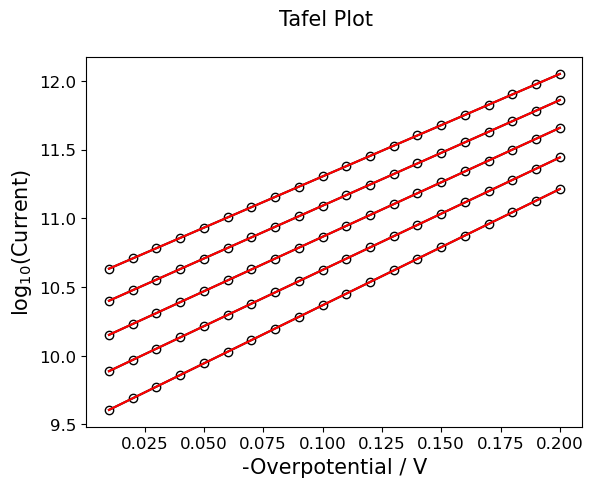

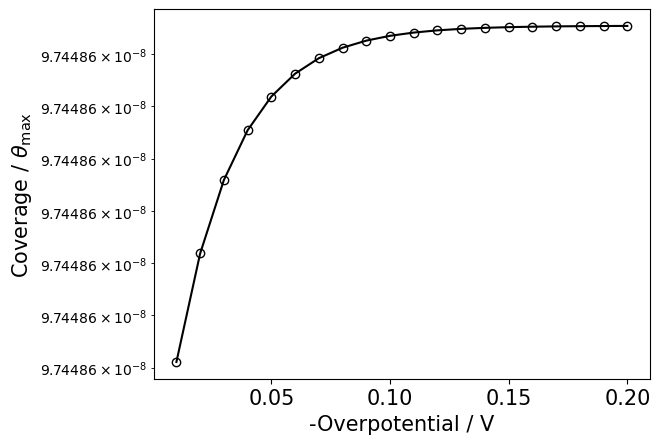

In [20]:
params, model_result, E_values, cov = simulation_E_T([-0.2, 0.0], A1, Ea1, A_1, A2, Ea2, 0.0, 1, 
    log_scale=True, regions=False, save=False, name='ExtArrheniusVHVRDS')

Slope: 118.259 mV/dec
Slope: 122.228 mV/dec
Slope: 126.196 mV/dec
Slope: 130.164 mV/dec
Slope: 134.133 mV/dec


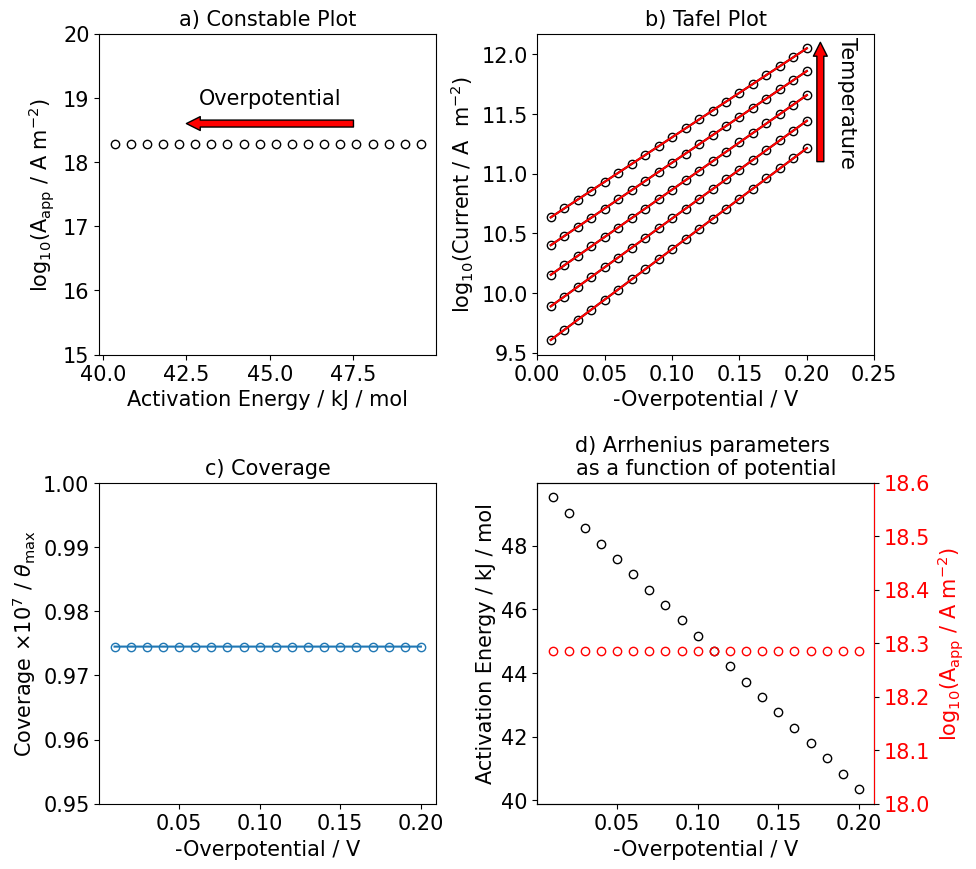

In [23]:
plot_constable_tafel(params, model_result, E_values, cov, arrowE=True, arrowT=True, Exy=[45, 19], cov_scale=[0.95, 1],
    Earrowxy=[42.5, 18.6, 47.5, 18.6], Tarrowxy=[0.21, 12.1, 0.21, 11.1], Txy=[0.23, 11.6], ylim=[15, 20],
    save=False, name='VH-VRDS')

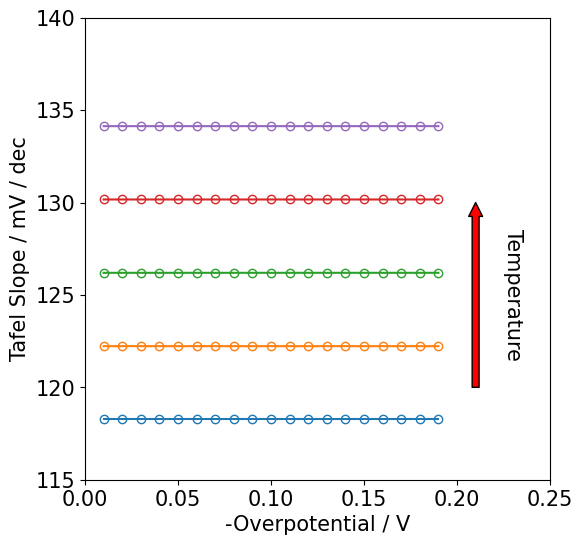

In [26]:
plot_tafel_slope(params, model_result, E_values, ylim=[115, 140], arrowT=True, 
    save=False, name='VH-VRDS-TS')

## Case 1.2 Volmer-Heyrovsky: Heyrovsky RDS -> $\Delta G^\ddagger_\mathrm{act, V} << \Delta G^\ddagger_\mathrm{act, H}$

In [28]:
A1 = 1e13
Ea1 = 10e3
A_1 = 1e13
A2 = 1e13
Ea2 = 50e3

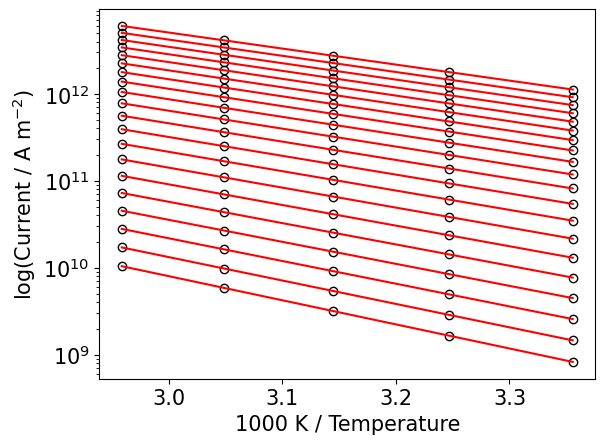

Slope till 0.08V @ 298: 42.916 mV/dec
Slope over 0.08V @ 298: 85.645 mV/dec
Slope till 0.08V @ 308: 44.556 mV/dec
Slope over 0.08V @ 308: 87.849 mV/dec
Slope till 0.08V @ 318: 46.208 mV/dec
Slope over 0.08V @ 318: 90.033 mV/dec
Slope till 0.08V @ 328: 47.871 mV/dec
Slope over 0.08V @ 328: 92.199 mV/dec
Slope till 0.08V @ 338: 49.545 mV/dec
Slope over 0.08V @ 338: 94.349 mV/dec


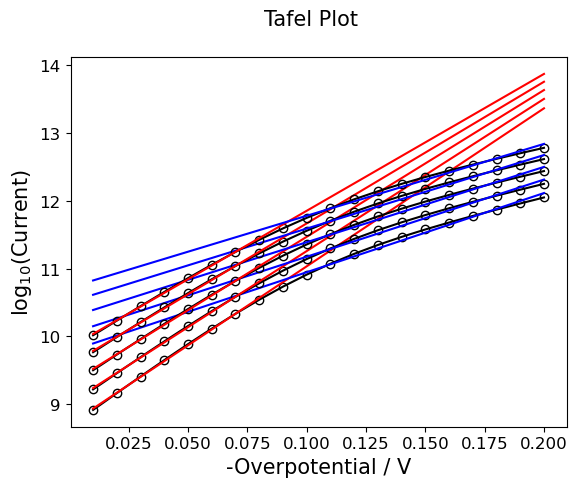

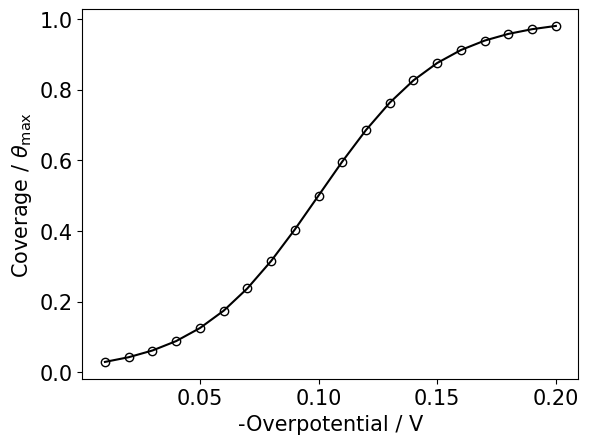

In [29]:
params, model_result, E_values, cov = simulation_E_T([-0.2, -0.00], A1, Ea1, A_1, A2, Ea2, -0.1, 1, log_scale=False, regions=True, cutoff=0.08)

In [30]:
k1 = k_arr(273+25, A1, Ea1)
k_1 = k_arr(273+25, A_1, Ea1)
k2 = k_arr(273+25, A2, Ea2)
alpha = 0.5
T = 273+25
Ev = -0.1
Eh = -Ev
Vfwd = lambda E: k1*(1-jssH(T, E, k1, k_1, k2, Ev=Ev)[1])*np.exp(-alpha*F*(E-Ev)/R/T)
Vbwd = lambda E: k_1*jssH(T, E, k1, k_1, k2, Ev=Ev)[1]*np.exp((1-alpha)*F*(E-Ev)/R/T)
Hfwd = lambda E: k2*jssH(T, E, k1, k_1, k2, Ev=Ev)[1]*np.exp(-alpha*F*(E-Eh)/R/T)

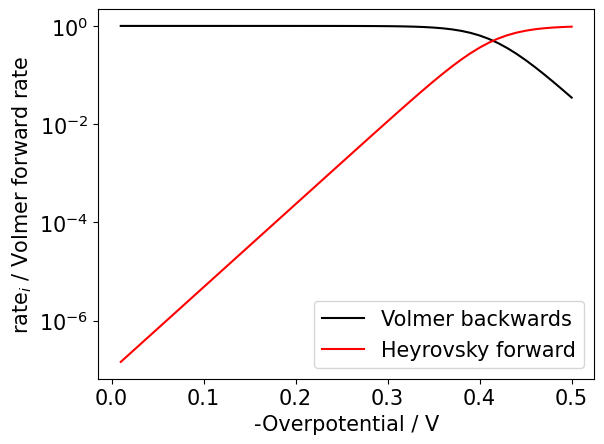

In [31]:
e_space = np.linspace(-0.5, -0.01, 50)

fig, ax = plt.subplots()
ax.plot(-e_space, Vbwd(e_space)/Vfwd(e_space), '-k', label='Volmer backwards')
ax.plot(-e_space, Hfwd(e_space)/Vfwd(e_space), '-r', label='Heyrovsky forward')
ax.set_xlabel('-Overpotential / V', fontsize=15)
ax.set_ylabel(r'rate$_i$ / Volmer forward rate', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=15)
ax.set_yscale('log')
#plt.savefig(f'../../Faraday Discussion/London - 2026/Figures/steadystaterates_VHHRDS.png', bbox_inches='tight')
plt.show()

Slope till 0.06V: 41.675 mV/dec
Slope over 0.15V: 108.351 mV/dec
Slope till 0.06V: 43.248 mV/dec
Slope over 0.15V: 111.099 mV/dec
Slope till 0.06V: 44.833 mV/dec
Slope over 0.15V: 113.787 mV/dec
Slope till 0.06V: 46.430 mV/dec
Slope over 0.15V: 116.416 mV/dec
Slope till 0.06V: 48.039 mV/dec
Slope over 0.15V: 118.991 mV/dec


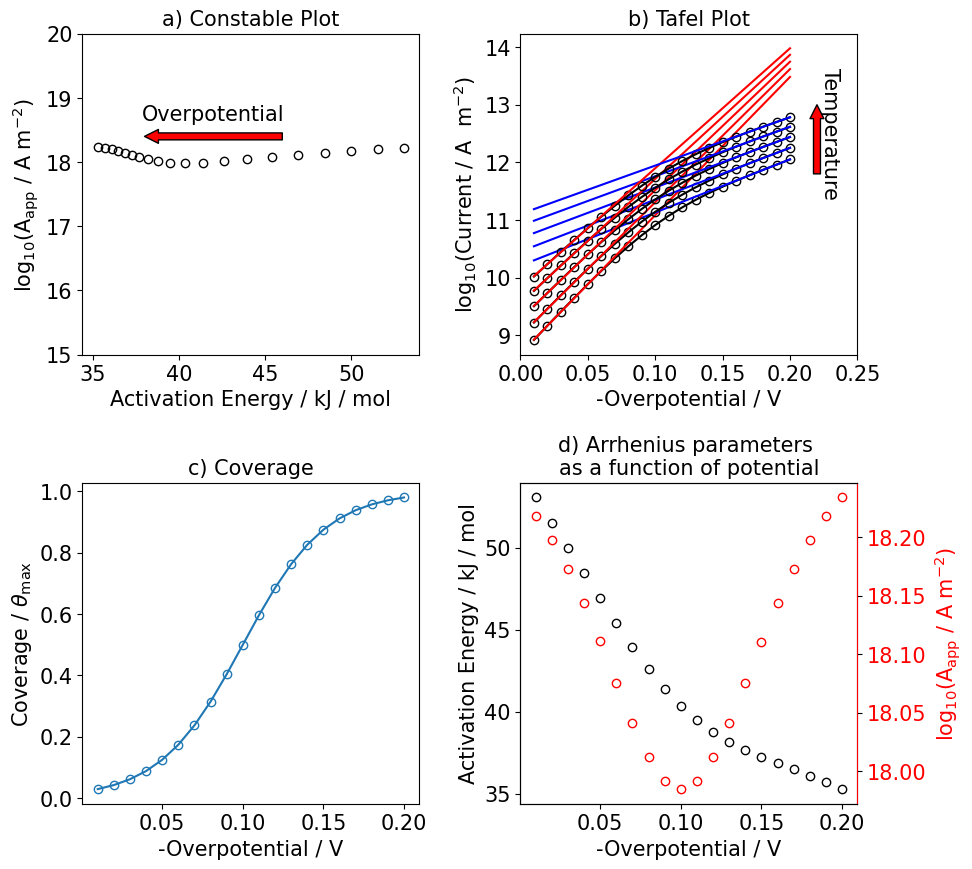

In [32]:
plot_constable_tafel(params, model_result, E_values, cov, k=1, regions=True, cutoff=[0.06, 0.15], arrowE=True, arrowT=True,
    Exy=[42, 18.75], Earrowxy=[38, 18.4, 46, 18.4], Txy=[0.23, 12.5], Tarrowxy=[0.22, 13, 0.22, 11.8], ylim=[15, 20],
    save=False, name='VH-HRDS')

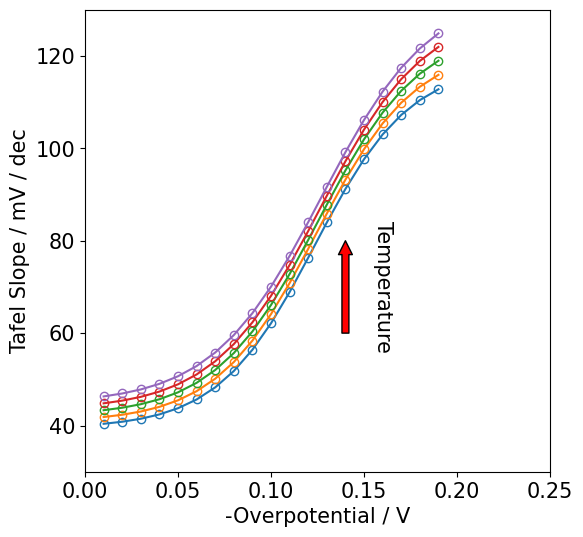

In [33]:
plot_tafel_slope(params, model_result, E_values, ylim=[30, 130], arrowT=True, Txy=[0.16, 70], Tarrowxy=[0.14, 80, 0.14, 60],
    save=False, name='VH-HRDS-TS-Eneg')

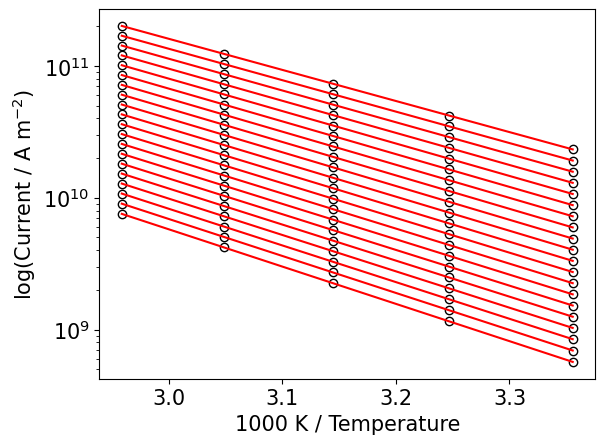

Slope till 0.08V @ 298: 117.228 mV/dec
Slope over 0.08V @ 298: 118.231 mV/dec
Slope till 0.08V @ 308: 120.969 mV/dec
Slope over 0.08V @ 308: 122.189 mV/dec
Slope till 0.08V @ 318: 124.677 mV/dec
Slope over 0.08V @ 318: 126.145 mV/dec
Slope till 0.08V @ 328: 128.350 mV/dec
Slope over 0.08V @ 328: 130.097 mV/dec
Slope till 0.08V @ 338: 131.987 mV/dec
Slope over 0.08V @ 338: 134.045 mV/dec


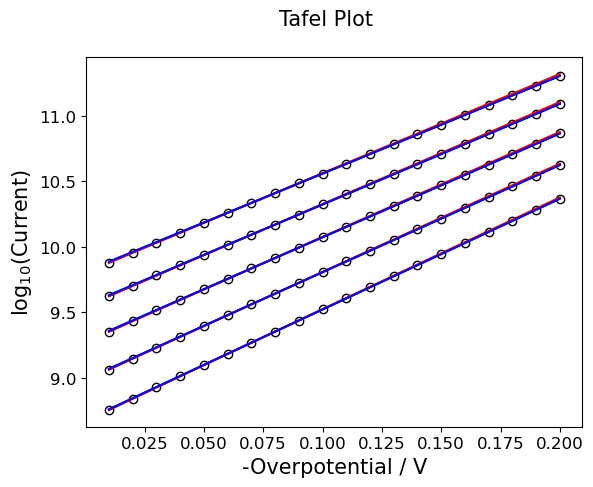

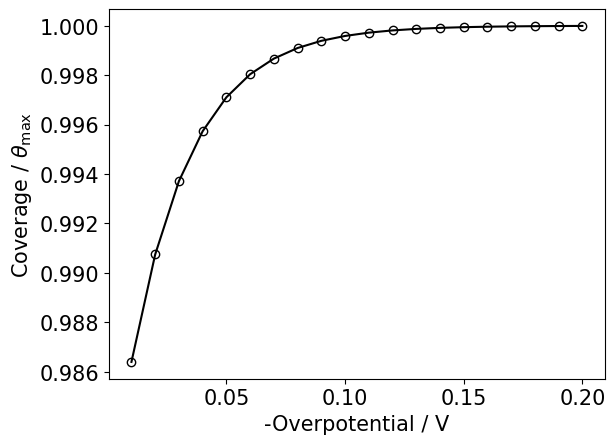

In [34]:
params, model_result, E_values, cov = simulation_E_T([-0.2, 0.0], A1, Ea1, A_1, A2, Ea2, 0.1, 1, log_scale=False, regions=True, cutoff=0.08)

Slope: 117.972 mV/dec
Slope: 121.870 mV/dec
Slope: 125.756 mV/dec
Slope: 129.628 mV/dec
Slope: 133.486 mV/dec


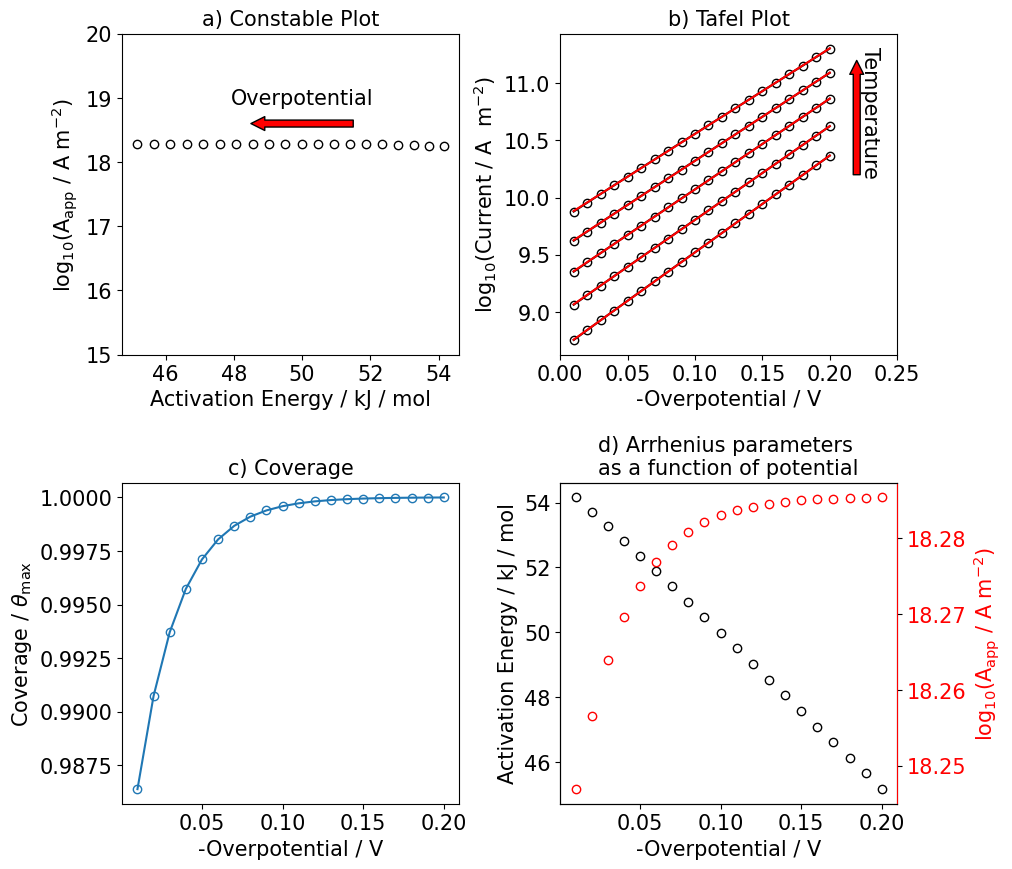

In [35]:
plot_constable_tafel(params, model_result, E_values, cov, k=1, regions=False, cutoff=0.1, arrowE=True, arrowT=True,
    Exy=[50, 19], Earrowxy=[48.5, 18.6, 51.5, 18.6], Txy=[0.23, 10.75], Tarrowxy=[0.22, 11.2, 0.22, 10.2], 
    ylim=[15, 20],
    save=False, name='VH-HRDS-Evpos')

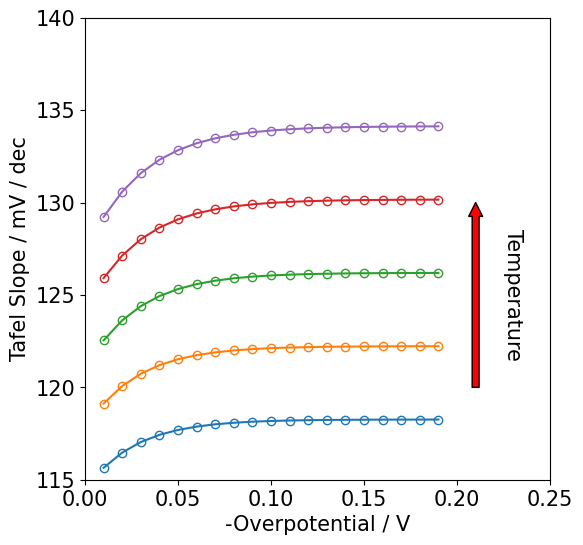

In [36]:
plot_tafel_slope(params, model_result, E_values, ylim=[115, 140], arrowT=True, 
    save=False, name='VH-HRDS-TS_Epos')

## Case 1.3 Volmer-Heyrovsky: Mix -> $\Delta G^\ddagger_\mathrm{act, V} = \Delta G^\ddagger_\mathrm{act, H}$

In [37]:
A1 = 1e13
Ea1 = 50e3
A_1 = 1e13
A2 = 1e11
Ea2 = 40e3

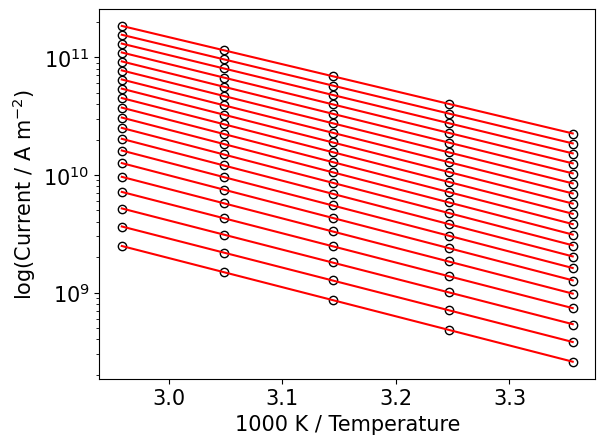

Slope till 0.10V @ 298: 84.694 mV/dec
Slope over 0.10V @ 298: 116.917 mV/dec
Slope till 0.10V @ 308: 84.315 mV/dec
Slope over 0.10V @ 308: 120.376 mV/dec
Slope till 0.10V @ 318: 83.931 mV/dec
Slope over 0.10V @ 318: 123.701 mV/dec
Slope till 0.10V @ 328: 83.582 mV/dec
Slope over 0.10V @ 328: 126.873 mV/dec
Slope till 0.10V @ 338: 83.299 mV/dec
Slope over 0.10V @ 338: 129.879 mV/dec


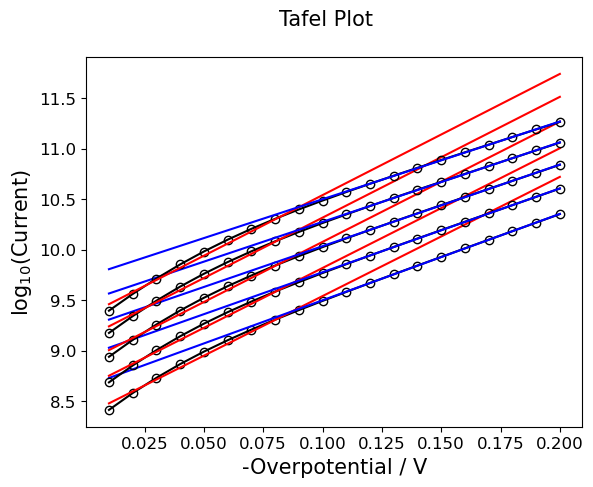

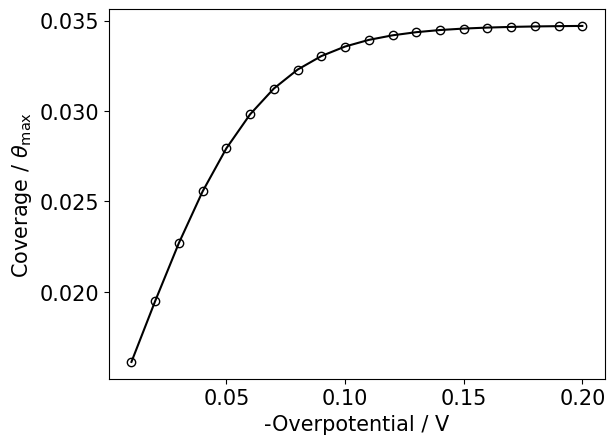

In [38]:
params, model_result, E_values, cov = simulation_E_T([-0.2, -0.00], A1, Ea1, A_1, A2, Ea2, -0.1, 1, 
    log_scale=False, regions=True, cutoff=0.1, save=False, name='ExtArrheniusVHmix')

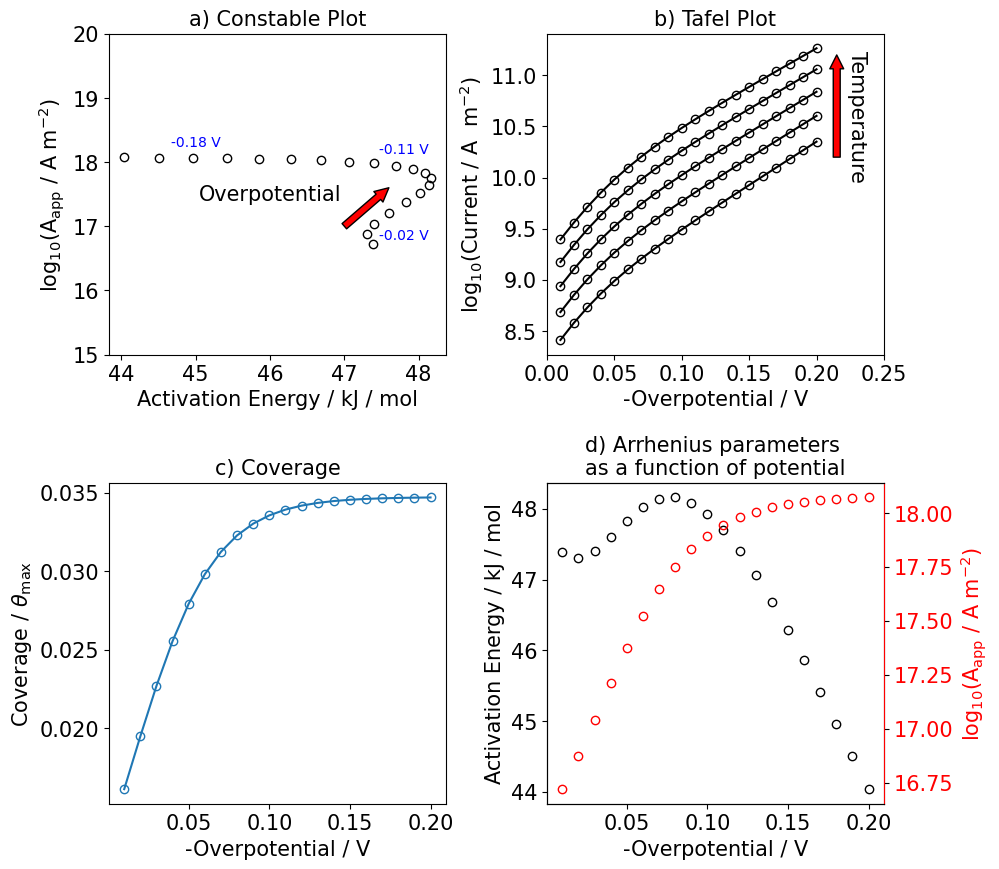

In [40]:
plot_constable_tafel(params, model_result, E_values, cov, k=1, regions=False, nofit=True, cutoff=0.08, 
    arrowE=True, arrowT=True, ind_labels=True,
    Earrowxy=[47.6, 17.6, 47.0, 17.], Exy=[46, 17.5], ylim=[15, 20], Tarrowxy=[0.215, 11.2, 0.215, 10.2], 
    Txy=[0.23, 10.6],
    save=False, name='VH-noRDS-Evneg')

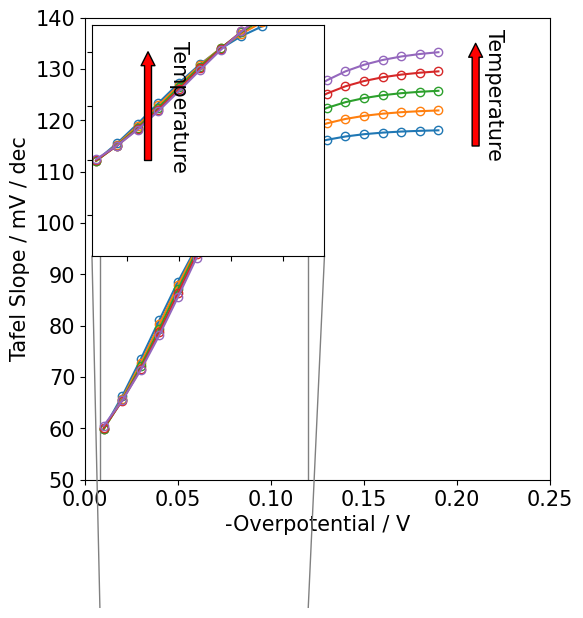

In [41]:
plot_tafel_slope(params, model_result, E_values, ylim=[50, 140], arrowT=True, Txy=[0.22, 125], Tarrowxy=[0.21, 135, 0.21, 115],
    inset=True, save=False, name='VH-mix-TS-Eneg')

In [43]:
def simulation_E_T(E_range, A1, Ea1, A_1, A2, Ea2, Ev, z, log_scale=False, regions=False, cutoff=0.1):
    T_values = np.linspace(273+25, 273+65, 5)
    E_values = np.arange(E_range[0], E_range[1], 0.01)
    params = {}
    model_result = np.zeros((len(E_values), len(T_values)))
    cov = []
    k = 0
    for E in E_values:
        params.update({f'{E:.2f}': np.array([])})
        j = 0
        for T in T_values:
            k1 = k_arr(T, A1, Ea1)
            k_1 = k_arr(T, A_1, Ea1)
            k2 = k_arr(T, A2, Ea2)
            if T == T_values.min():
                cov += [jssT(E, k1, k_1, k2, T, Ev=Ev)[1]]
            model_result[k, j] += jssT(E, k1, k_1, k2, T, Ev=Ev)[0]
            j += 1
        k += 1
    fig, ax = plt.subplots()
    for i in range(len(model_result)):
        ax.plot(1000/T_values, model_result[i], 'ok', fillstyle='none')
        popt, pcov = curve_fit(lin, 1/T_values, np.log(model_result[i]))
        #print('R2 = ', R2(1/T_values, np.log(model_result[i]), popt))
        params[f'{E_values[i]:.2f}'] = np.append(params[f'{E_values[i]:.2f}'], [-R*popt[0], np.log10(np.exp(popt[1]))])
        ax.plot(1000/T_values, np.exp(lin(1/T_values, *popt)), '-r')
    ax.set_xlabel('1000 K / Temperature', fontsize=15)
    ax.set_ylabel('log(Current)', fontsize=15)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()
    
    fig, ax = plt.subplots()
    fig.suptitle('Tafel Plot', fontsize=15)
    for i in range(len(model_result.T)):
        ax.plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff)], np.log10(model_result.T[i][(-E_values < cutoff)]))
                print(f'Slope till {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff)], np.log10(model_result.T[i][(-E_values >= cutoff)]))
                print(f'Slope over {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt2[0]:.3f} mV/dec')
                ax.plot(-E_values, lin(-E_values, *popt1), '-r')
                ax.plot(-E_values, lin(-E_values, *popt2), '-b')
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope @ {T_values[i]:.0f}: {1000/popt[0]:.3f} mV/dec')
            ax.plot(-E_values, lin(-E_values, *popt), '-r')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'log$_{10}$(Current)', fontsize=15)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(-E_values, cov, 'o-k', fillstyle='none')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    if log_scale:
        ax.set_yscale('log')
    plt.show()
    
    return params, model_result, E_values, np.array(cov)

## Case 2.1 Volmer-Tafel: Volmer RDS -> $\Delta G^\ddagger_\mathrm{act, V} >> \Delta G^\ddagger_\mathrm{act, T}$

In [44]:
A1 = 1e13
Ea1 = 50e3
A_1 = 1e13
A2 = 1e13
Ea2 = 10e3

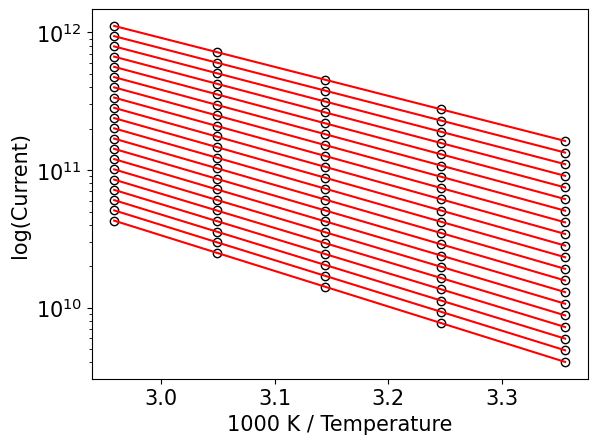

Slope @ 298: 118.310 mV/dec
Slope @ 308: 122.293 mV/dec
Slope @ 318: 126.278 mV/dec
Slope @ 328: 130.266 mV/dec
Slope @ 338: 134.257 mV/dec


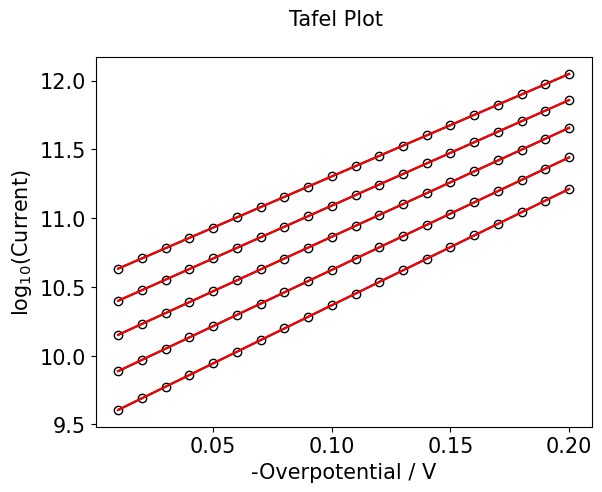

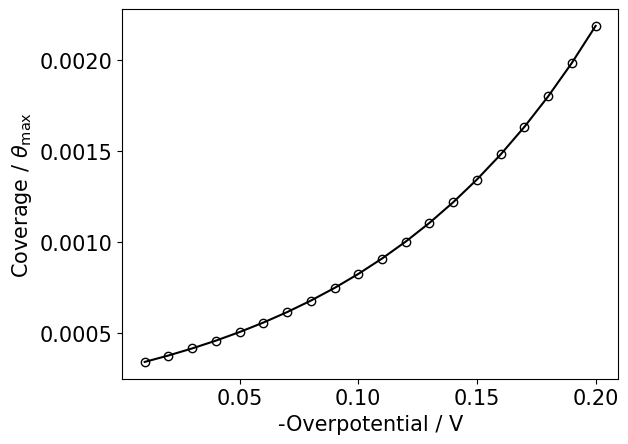

In [45]:
params, model_result, E_values, cov = simulation_E_T([-0.2, 0.0], A1, Ea1, A_1, A2, Ea2, 0.0, 1, log_scale=False, regions=False, cutoff=0.3)

Slope: 118.310 mV/dec
Slope: 122.293 mV/dec
Slope: 126.278 mV/dec
Slope: 130.266 mV/dec
Slope: 134.257 mV/dec


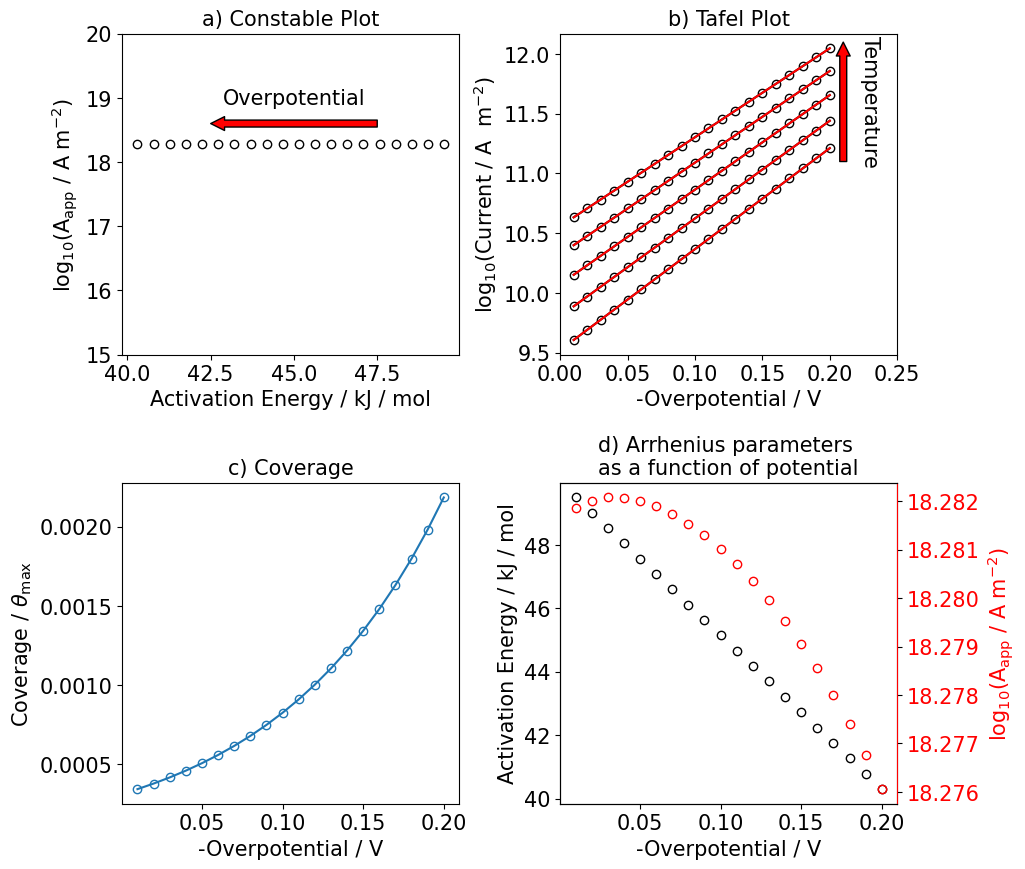

In [46]:
plot_constable_tafel(params, model_result, E_values, cov, arrowE=True, arrowT=True, Exy=[45, 19], cov_scale=[-0.1, 0.5],
    Earrowxy=[42.5, 18.6, 47.5, 18.6], Tarrowxy=[0.21, 12.1, 0.21, 11.1], Txy=[0.23, 11.6], ylim=[15, 20],
    save=False, name='VT-VRDS')

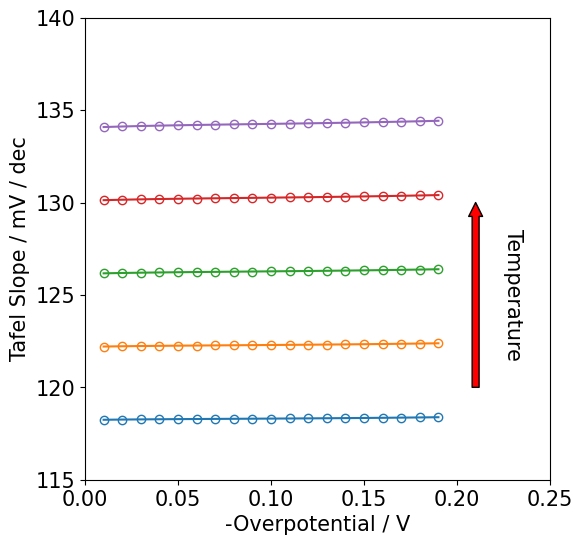

In [68]:
plot_tafel_slope(params, model_result, E_values, ylim=[115, 140], arrowT=True, 
    save=False, name='VT-VRDS-TS')

## Case 2.2 Volmer-Tafel: Tafel RDS -> $\Delta G^\ddagger_\mathrm{act, V} << \Delta G^\ddagger_\mathrm{act, T}$

In [47]:
A1 = 1e13
A_1 = 1e13
Ea1 = 10e3
A2 = 1e13
Ea2 = 50e3

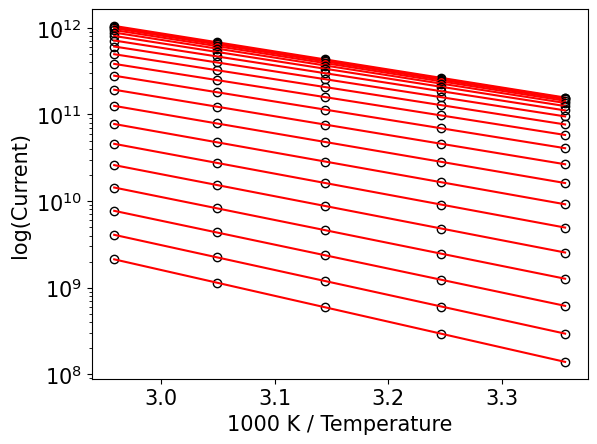

Slope till 0.06V @ 298: 32.177 mV/dec
Slope over 0.06V @ 298: 113.987 mV/dec
Slope till 0.06V @ 308: 33.465 mV/dec
Slope over 0.06V @ 308: 115.994 mV/dec
Slope till 0.06V @ 318: 34.769 mV/dec
Slope over 0.06V @ 318: 117.974 mV/dec
Slope till 0.06V @ 328: 36.088 mV/dec
Slope over 0.06V @ 328: 119.933 mV/dec
Slope till 0.06V @ 338: 37.423 mV/dec
Slope over 0.06V @ 338: 121.872 mV/dec


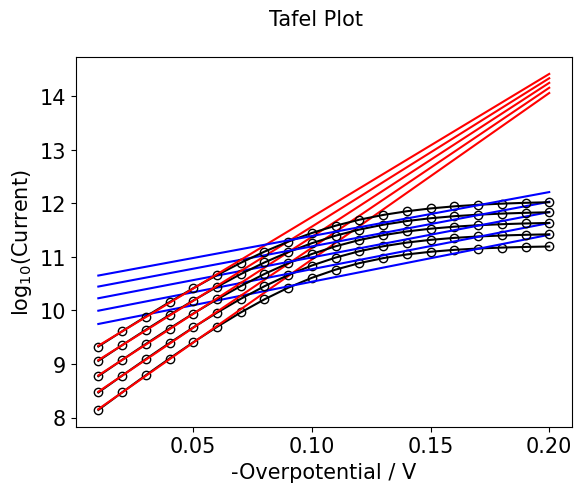

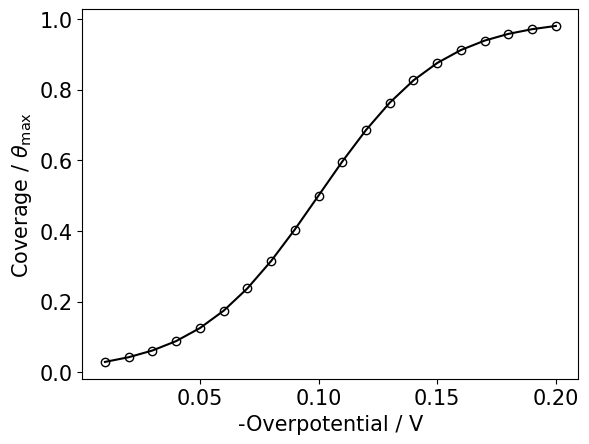

In [48]:
params, model_result, E_values, cov = simulation_E_T([-0.2, 0.0], A1, Ea1, A_1, A2, Ea2, -0.1, 1, regions=True, cutoff=0.06)

Slope till 0.06V: 32.177 mV/dec
Slope over 0.12V: 338.094 mV/dec
Slope till 0.06V: 33.465 mV/dec
Slope over 0.12V: 328.389 mV/dec
Slope till 0.06V: 34.769 mV/dec
Slope over 0.12V: 319.859 mV/dec
Slope till 0.06V: 36.088 mV/dec
Slope over 0.12V: 312.340 mV/dec
Slope till 0.06V: 37.423 mV/dec
Slope over 0.12V: 305.701 mV/dec


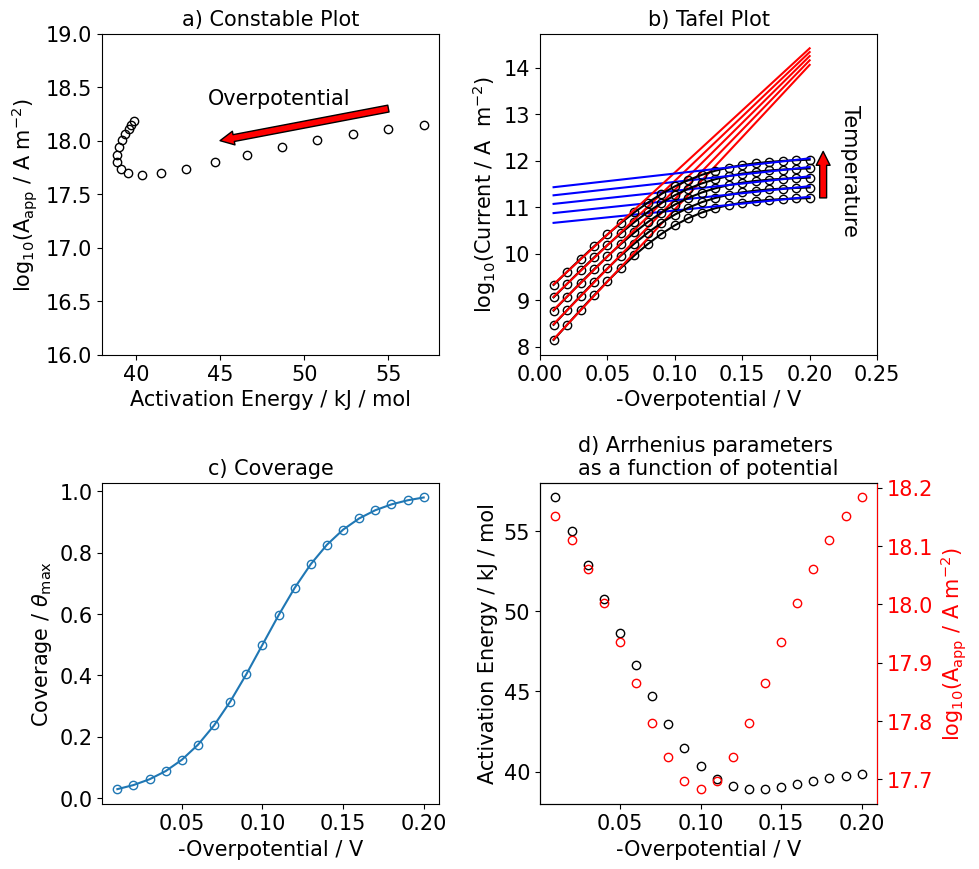

In [49]:
plot_constable_tafel(params, model_result, E_values, cov, k=1, arrowE=True, arrowT=True, Exy=[48.5, 18.4],
    Earrowxy=[45, 18, 55, 18.3], Txy=[0.23, 11.8], Tarrowxy=[0.21, 12.2, 0.21, 11.2], regions=True, cutoff=[0.06, 0.12],
    ylim=[16, 19], save=False, name='VT-VRDS-Evneg')

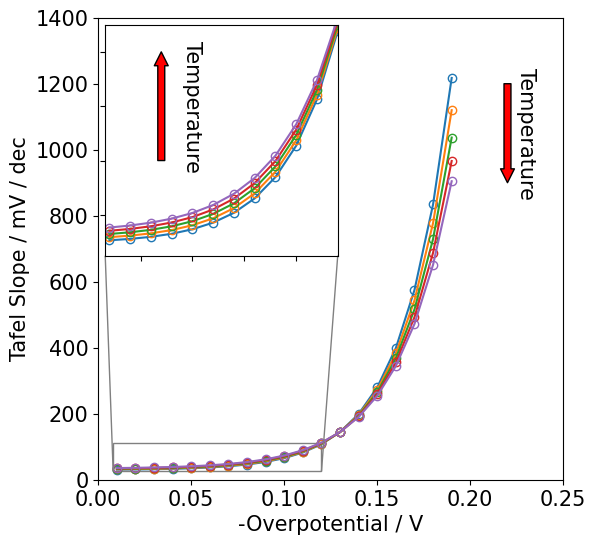

In [50]:
plot_tafel_slope(params, model_result, E_values, ylim=[0, 1400], arrowT=True, Txy=[0.23, 1050],
    Tarrowxy=[0.22, 900, 0.22, 1200], inset=True,
    save=False, name='VT-TRDS-TS')

# Two Active Sites

In [51]:
def simulation_E_T(E_range, A1, Ea1, A_1, A2, Ea2, Ev, z, log_scale=True, regions=False, cutoff=0.1):
    T_values = np.linspace(273+25, 273+65, 5)
    E_values = np.arange(E_range[0], E_range[1], 0.01)
    params = {}
    model_result = np.zeros((len(E_values), len(T_values)))
    cov = []
    k = 0
    for E in E_values:
        params.update({f'{E:.2f}': np.array([])})
        j = 0
        for T in T_values:
            k1 = k_arr(T, A1, Ea1)
            k_1 = k_arr(T, A_1, Ea1)
            k2 = k_arr(T, A2, Ea2)
            if T == T_values.min():
                ind_cov = np.zeros(len(Ev))
            for V in range(len(Ev)):
                if T == T_values.min():
                    ind_cov[V] += jssH(T, E, k1, k_1, k2, Ev=Ev[V])[1]
                model_result[k, j] += jssH(T, E, k1, k_1, k2, Ev=Ev[V])[0]
            j += 1
        cov += [ind_cov]
        k += 1
    cov = np.array(cov)
    
    fig, ax = plt.subplots()
    for i in range(len(model_result)):
        ax.plot(1000/T_values, model_result[i], 'ok', fillstyle='none')
        popt, pcov = curve_fit(lin, 1/T_values, np.log(model_result[i]))
        params[f'{E_values[i]:.2f}'] = np.append(params[f'{E_values[i]:.2f}'], [-R*popt[0], np.log10(np.exp(popt[1]))])
        ax.plot(1000/T_values, np.exp(lin(1/T_values, *popt)), '-r')
    ax.set_xlabel('1000 K / Temperature', fontsize=15)
    ax.set_ylabel('log(Current)', fontsize=15)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()
    
    fig, ax = plt.subplots()
    for i in range(len(model_result.T)):
        ax.plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff)], np.log10(model_result.T[i][(-E_values < cutoff)]))
                print(f'Slope till {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff)], np.log10(model_result.T[i][(-E_values >= cutoff)]))
                print(f'Slope over {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt2[0]:.3f} mV/dec')
                ax.plot(-E_values, lin(-E_values, *popt1), '-r')
                ax.plot(-E_values, lin(-E_values, *popt2), '-b')
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope @ {T_values[i]:.0f}: {1000/popt[0]:.3f} mV/dec')
            ax.plot(-E_values, lin(-E_values, *popt), '-r')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'log$_{10}$(Current)', fontsize=15)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()
    

    fig, ax = plt.subplots()
    for i in range(len(cov.T)):
        ax.plot(-E_values, cov.T[i], 'o-', fillstyle='none', label=f'Ev = {Ev[i]:.2f} V')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=15)
    if log_scale:
        ax.set_yscale('log')
    plt.show()
    
    return params, model_result, E_values, cov

In [56]:
def plot_constable_tafel(fit_params, model_result, E_values, cov, Ev, regions=False, nofit=False, cutoff=[0.1, 0.1], k = 1, log_scale=False,
        arrowE=False, arrowT=False, Exy=[44, 13.5], Earrowxy=[42, 13, 46, 13],
        Txy=[0.23, 6.3], Tarrowxy=[0.21, 6.7, 0.21, 6], ylim=[15, 20], xlim=[-0.01, 0.25],
        save=False, name='DummyFigure'):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    
    ax[0, 0].set_title('a) Constable Plot', fontsize=15)
    for i in fit_params.keys():
        if k == 0:
            ax[0, 0].plot(fit_params[i][0]/1000, fit_params[i][1], 'xr', fillstyle='none')
            k += 1
        else:
            ax[0, 0].plot(fit_params[i][0]/1000, fit_params[i][1], 'ok', fillstyle='none')
    if arrowE:
        ax[0, 0].annotate("Overpotential", (Exy[0], Exy[1]), fontsize=15, ha='center', va='center')
        ax[0, 0].annotate("", (Earrowxy[0], Earrowxy[1]), xytext=(Earrowxy[2], Earrowxy[3]),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
    ax[0, 0].set_xlabel('Activation Energy / kJ / mol', fontsize=15)
    ax[0, 0].set_ylabel(r'log$_{10}$(A$_\mathrm{app}$ / A m$^{-2}$)', fontsize=15)
    ax[0, 0].tick_params(axis='both', labelsize=15)
    ax[0, 0].set_ylim(ylim[0], ylim[1])

    ax[0, 1].set_title('b) Tafel Plot', fontsize=15)
    for i in range(len(model_result.T)):
        ax[0, 1].plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff[0])], np.log10(model_result.T[i][(-E_values < cutoff[0])]))
                print(f'Slope till {cutoff[0]:.2f}V: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff[1])], np.log10(model_result.T[i][(-E_values >= cutoff[1])]))
                print(f'Slope over {cutoff[1]:.2f}V: {1000/popt2[0]:.3f} mV/dec')
                ax[0, 1].plot(-E_values, lin(-E_values, *popt1), '-r')
                ax[0, 1].plot(-E_values, lin(-E_values, *popt2), '-b')
        elif nofit:
            pass
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope: {1000/popt[0]:.3f} mV/dec')
            ax[0, 1].plot(-E_values, lin(-E_values, *popt), '-r')
    if arrowT:
        ax[0, 1].annotate("Temperature", (Txy[0], Txy[1]), rotation=270, fontsize=15, ha='center', va='center')
        ax[0, 1].annotate("", (Tarrowxy[0], Tarrowxy[1]), xytext=(Tarrowxy[2], Tarrowxy[3]),
            arrowprops={'width': 5, 'headwidth': 10, 'headlength': 10, 'facecolor': 'red', 'edgecolor': 'black'}, ha='center', va='center')
    ax[0, 1].set_xlabel('-Overpotential / V', fontsize=15)
    ax[0, 1].set_ylabel(r'log$_{10}$(Current / A  m$^{-2}$)', fontsize=15)
    #ax.set_yscale('log')
    ax[0, 1].set_xlim(xlim[0], xlim[1])
    ax[0, 1].tick_params(axis='both', labelsize=15)
    
    ax[1, 0].set_title('c) Coverage at different sites', fontsize=15)
    for i in range(len(cov.T)):
        ax[1, 0].plot(-E_values, cov.T[i], 'o-', fillstyle='none', label=r'$\mathrm{E^0_V}$ = ' + f'{Ev[i]:.2f} V')
    ax[1, 0].set_xlabel('-Overpotential / V', fontsize=15)
    ax[1, 0].set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    ax[1, 0].tick_params(axis='both', labelsize=15)
    ax[1, 0].legend(fontsize=15)
    #ax.axvline(0.1, ymin=0, ymax=1)
    #ax.axhline(0.5, xmin=0, xmax=1)
    if log_scale:
        ax[1, 0].set_yscale('log')
    
    Ea = np.array([fit_params[i][0] for i in fit_params.keys()])
    A  = np.array([fit_params[i][1] for i in fit_params.keys()])
    ax[1, 1].set_title('d) Arrhenius parameters \nas a function of potential', fontsize=15)
    ax[1, 1].plot(-E_values, Ea/1000, 'ok', fillstyle='none')
    twinx = ax[1, 1].twinx()
    twinx.plot(-E_values, A, 'or', fillstyle='none')
    
    ax[1, 1].set_xlabel('-Overpotential / V', fontsize=15)
    ax[1, 1].set_ylabel('Activation Energy / kJ / mol', fontsize=15)
    ax[1, 1].tick_params(axis='both', labelsize=15)
    twinx.set_ylabel(r'log$_{10}$(A$_\mathrm{app}$ / A m$^{-2}$)', fontsize=15, color='red')
    twinx.tick_params(axis='y', labelcolor='red', labelsize=15)
    twinx.spines['right'].set_color('red')
    #twinx.yaxis.label.set_color('red')
    #twinx.set_ylim(17, 18.3)
    if save:
        plt.savefig(f'../../Faraday Discussion/London - 2026/Figures/{name}.png', bbox_inches='tight')
    plt.show()

In [52]:
A1 = 1e13
A_1 = 1e13
Ea1 = 10e3
A2 = 1e13
Ea2 = 50e3
Ev = [0.15, -0.05]

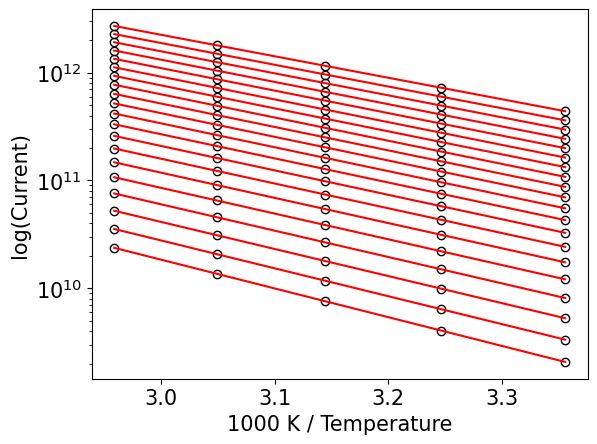

Slope @ 298: 85.739 mV/dec
Slope @ 308: 88.316 mV/dec
Slope @ 318: 90.884 mV/dec
Slope @ 328: 93.445 mV/dec
Slope @ 338: 96.000 mV/dec


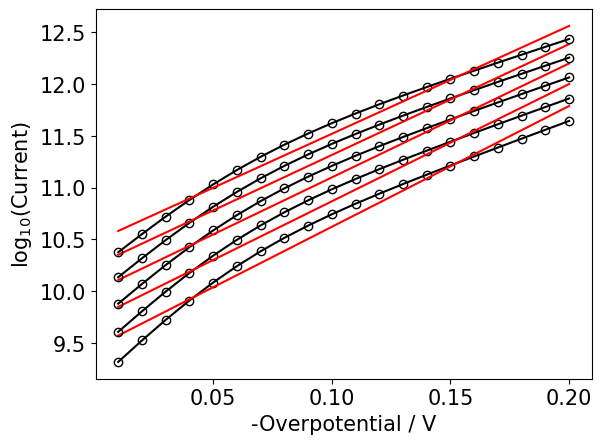

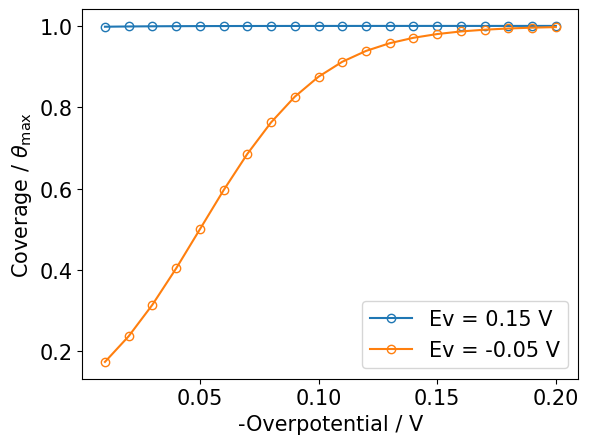

In [53]:
params, model_result, E_values, cov = simulation_E_T([-0.2, -0.00], A1, Ea1, A_1, A2, Ea2, Ev, 1, log_scale=False, regions=False, cutoff=0.07)

Slope till 0.06V: 53.962 mV/dec
Slope over 0.12V: 115.114 mV/dec
Slope till 0.06V: 56.154 mV/dec
Slope over 0.12V: 118.553 mV/dec
Slope till 0.06V: 58.370 mV/dec
Slope over 0.12V: 121.942 mV/dec
Slope till 0.06V: 60.609 mV/dec
Slope over 0.12V: 125.283 mV/dec
Slope till 0.06V: 62.871 mV/dec
Slope over 0.12V: 128.576 mV/dec


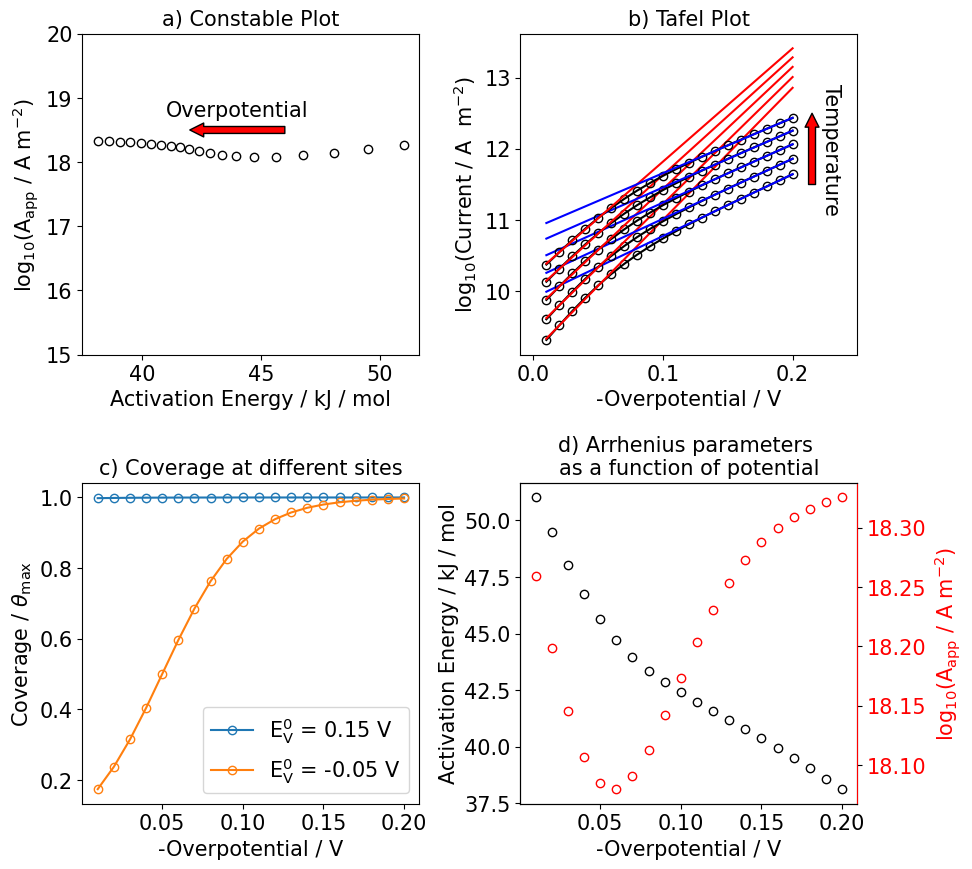

In [57]:
plot_constable_tafel(params, model_result, E_values, cov, Ev, regions=True, cutoff=[0.06, 0.12], log_scale=False,
    arrowT=True, arrowE=True, Exy=[44, 18.8], Earrowxy=[42, 18.5, 46, 18.5], Txy=[0.23, 12], Tarrowxy=[0.215, 12.5, 0.215, 11.5],
    save=False, name='2sites-VH')

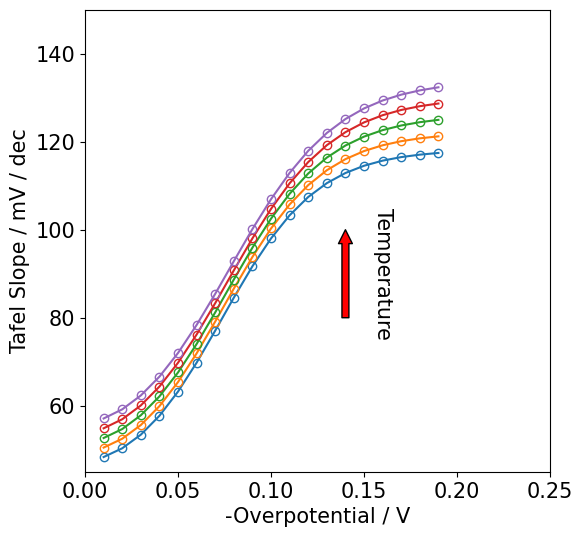

In [58]:
plot_tafel_slope(params, model_result, E_values, ylim=[45, 150], arrowT=True, Txy=[0.16, 90], Tarrowxy=[0.14, 100, 0.14, 80],
    save=False, name='2sites-VH-TS')

In [69]:
def simulation_E_T(E_range, A1, Ea1, A_1, A2, Ea2, Ev, z, log_scale=False, regions=False, cutoff=0.1):
    T_values = np.linspace(273+25, 273+70, 5)
    E_values = np.arange(E_range[0], E_range[1], 0.01)
    params = {}
    cov = []
    model_result = np.zeros((len(E_values), len(T_values)))
    k = 0
    for E in E_values:
        params.update({f'{E:.2f}': np.array([])})
        j = 0
        for T in T_values:
            k1 = k_arr(T, A1, Ea1)
            k_1 = k_arr(T, A_1, Ea1)
            k2 = k_arr(T, A2, Ea2)
            if T == T_values.min():
                ind_cov = np.zeros(len(Ev))
            for V in range(len(Ev)):
                if T == T_values.min():
                    ind_cov[V] += jssT(E, k1, k_1, k2, T, Ev=Ev[V])[1]

                    #fig, ax = plt.subplots()
                    #fig.suptitle(f'Eapp = {E:.2f} V, T = {T:.2f} K, Ev = {Ev[V]:.2f} V', fontsize=15)
                    #ax.plot(sol.t, sol.y[0])
                    #ax.set_xlabel('Time / seconds', fontsize=15)
                    #ax.set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
                    #ax.tick_params(axis='both', labelsize=15)
                    #plt.show()
                #print('Ev = ', Ev[V])
                #print('Model Result = ', model_result[k, j])
                #print('Site specific current = ', jssH(E, k1, T, sol.y[0][-1], Ev[V]))
                model_result[k, j] += jssT(E, k1, k_1, k2, T, Ev=Ev[V])[0]
                #print('Model Result = ', model_result[k, j])
                #print('#####')
            j += 1
        cov += [ind_cov]
        k += 1

    cov = np.array(cov)
    fig, ax = plt.subplots()
    for i in range(len(model_result)):
        ax.plot(1000/T_values, model_result[i], 'ok', fillstyle='none')
        popt, pcov = curve_fit(lin, 1/T_values, np.log(model_result[i]))
        params[f'{E_values[i]:.2f}'] = np.append(params[f'{E_values[i]:.2f}'], [-R*popt[0], np.log10(np.exp(popt[1]))])
        ax.plot(1000/T_values, np.exp(lin(1/T_values, *popt)), '-r')
    ax.set_xlabel('1000 K / Temperature', fontsize=15)
    ax.set_ylabel('log(Current)', fontsize=15)
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()
    
    fig, ax = plt.subplots()
    for i in range(len(model_result.T)):
        ax.plot(-E_values, np.log10(model_result.T[i]), 'o-k', fillstyle='none')
        if regions:
                popt1, pcov = curve_fit(lin, -E_values[(-E_values < cutoff)], np.log10(model_result.T[i][(-E_values < cutoff)]))
                print(f'Slope till {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt1[0]:.3f} mV/dec')
                popt2, pcov = curve_fit(lin, -E_values[(-E_values >= cutoff)], np.log10(model_result.T[i][(-E_values >= cutoff)]))
                print(f'Slope over {cutoff:.2f}V @ {T_values[i]:.0f}: {1000/popt2[0]:.3f} mV/dec')
                ax.plot(-E_values, lin(-E_values, *popt1), '-r')
                ax.plot(-E_values, lin(-E_values, *popt2), '-b')
        else:
            popt, pcov = curve_fit(lin, -E_values, np.log10(model_result.T[i]))
            print(f'Slope @ {T_values[i]:.0f}: {1000/popt[0]:.3f} mV/dec')
            #ax.plot(-E_values, lin(-E_values, *popt), '-r')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'log$_{10}$(Current)', fontsize=15)
    #ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=15)
    plt.show()

    
    fig, ax = plt.subplots()
    for i in range(len(cov.T)):
        ax.plot(-E_values, cov.T[i], 'o-', fillstyle='none', label=f'Ev = {Ev[i]:.2f} V')
    ax.set_xlabel('-Overpotential / V', fontsize=15)
    ax.set_ylabel(r'Coverage / $\theta_\mathrm{max}$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=15)
    #ax.axvline(0.1, ymin=0, ymax=1)
    #ax.axhline(0.5, xmin=0, xmax=1)
    if log_scale:
        ax.set_yscale('log')
    plt.show()
    return params, model_result, E_values, cov

In [70]:
A1 = 1e13
A_1 = 1e13
Ea1 = 10e3
A2 = 1e13
Ea2 = 50e3
Ev = [-0.15, 0.05]

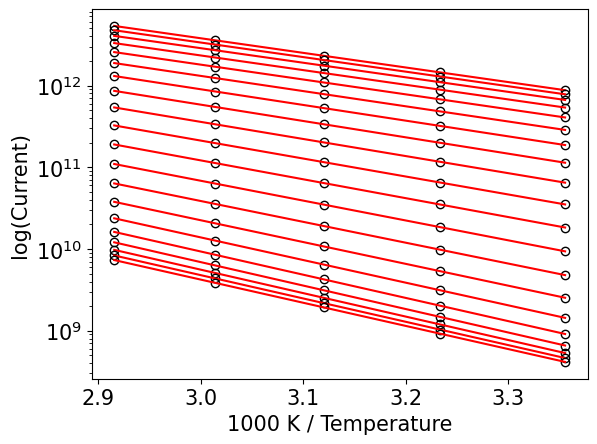

Slope @ 298: 48.372 mV/dec
Slope @ 309: 50.547 mV/dec
Slope @ 320: 52.753 mV/dec
Slope @ 332: 54.988 mV/dec
Slope @ 343: 57.254 mV/dec


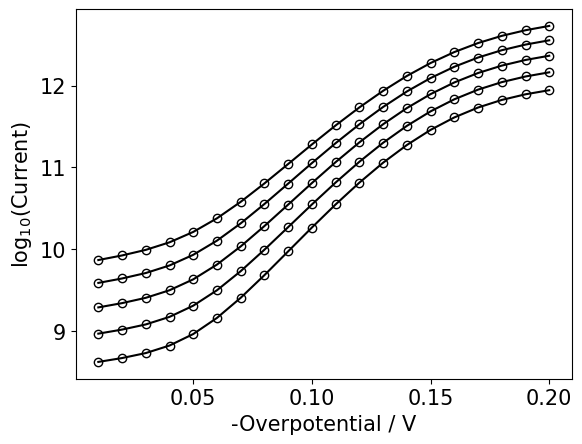

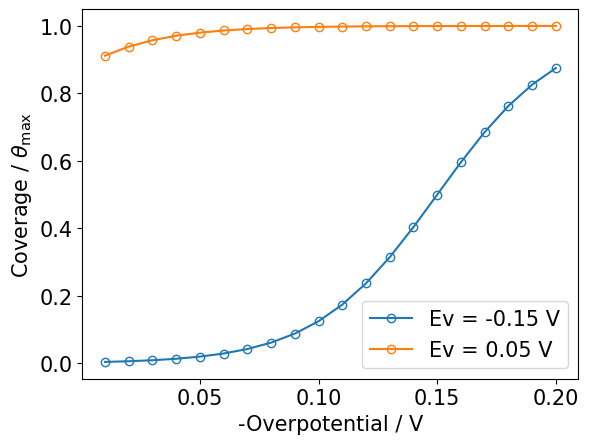

In [71]:
params, model_result, E_values, cov = simulation_E_T([-0.2, 0.0], A1, Ea1, A_1, A2, Ea2, Ev, 1, log_scale=False, regions=False, cutoff=0.03)

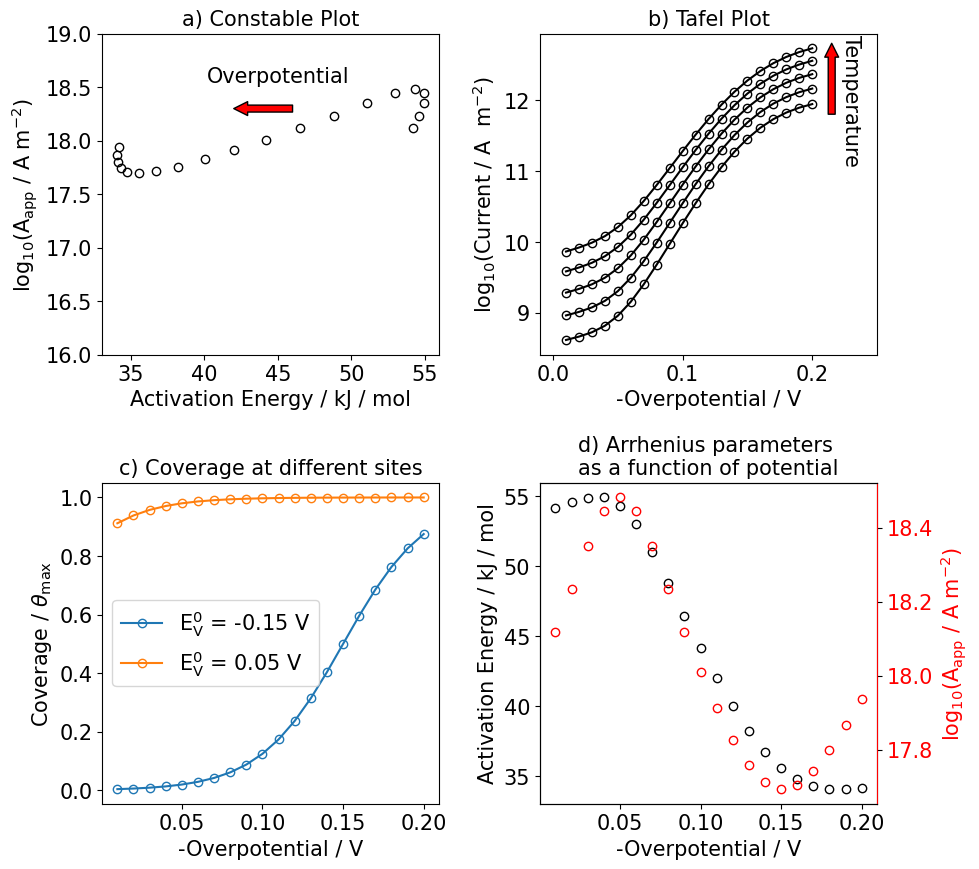

In [72]:
plot_constable_tafel(params, model_result, E_values, cov, Ev, 
    arrowT=True, arrowE=True, Exy=[45, 18.6], Earrowxy=[42, 18.3, 46, 18.3], Txy=[0.23, 12.], Tarrowxy=[0.215, 12.8, 0.215, 11.8],
    save=True, name='2sites-VT', nofit=True, ylim=[16, 19])

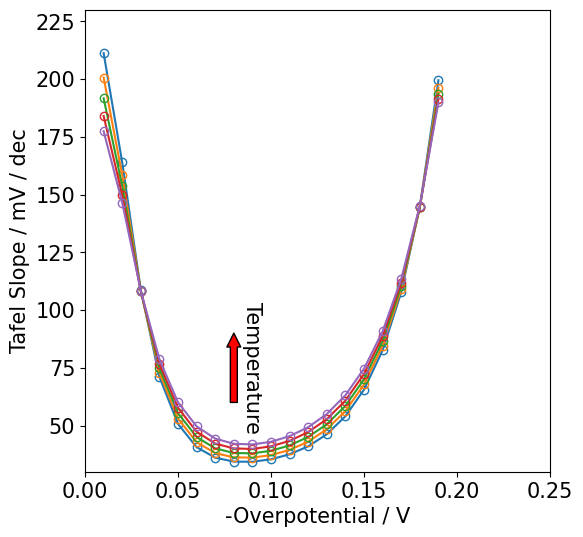

In [73]:
plot_tafel_slope(params, model_result, E_values, ylim=[30, 230], arrowT=True, Txy=[0.09, 75], Tarrowxy=[0.08, 90, 0.08, 60],
    save=False, name='2sites-VT-TS')